<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled223.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gemmi -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.5 MB/s eta 0:00:00


In [ ]:
# ================================================================
# 🧩 Minimal geometry stub for testing the GQR–TDSE runner
# (This just creates a small synthetic structure so the TDSE block runs)
# ================================================================
import numpy as np

# simple 6-node mock geometry: 2 metals, 2 μ-oxo, 2 waters
nodes = np.array([
    [0.0, 0.0, 0.0],    # Mn1
    [2.5, 0.0, 0.0],    # Mn2
    [1.2, 1.0, 0.0],    # μ-oxo1
    [1.2,-1.0, 0.0],    # μ-oxo2
    [0.0, 2.0, 0.0],    # water1
    [2.5, 2.0, 0.0],    # water2
], dtype=float)

labels = ["Mn1","Mn2","O1","O2","W1","W2"]
groups = ["metal","metal","mu-oxo","mu-oxo","water","water"]

N = len(nodes)

# pairwise distances and edges (cutoff ≤ 3.0 Å)
pairs = []
for i in range(N):
    for j in range(i+1, N):
        r = np.linalg.norm(nodes[i]-nodes[j])
        if r <= 3.0:
            pairs.append((i,j,r))
pairs = np.array(pairs, dtype=object)

# zero jitter by default
jitter = np.zeros(len(pairs), float)

print(f"✅ Synthetic geometry built: N={N}, edges={len(pairs)}")

✅ Synthetic geometry built: N=6, edges=11


In [ ]:
# ================================================================
# 🔧 Minimal setup for GQR–TDSE runner
# - Safe defaults so the TDSE runner block can execute
# ================================================================
import numpy as np

# --- Basic TDSE numeric parameters ---
T0       = 1.0          # base coupling strength
beta0    = 1.0          # exponential decay constant
DT_FS    = 0.5          # time step (fs)
N_STEPS  = 600          # total steps

# --- Metadata for saved filenames ---
SPECIES  = "OEC"
E_eV     = 1.0
SNAP_STEPS = {0, 10, 50, 100, 200, 400, 600}

# --- Placeholder gain function (replace with your physics later) ---
def gqr_gain(r, occ_ij, pars):
    """Simple monotone gain (placeholder)."""
    alpha = float(pars.get("ALPHA", 0.8)) if isinstance(pars, dict) else 0.8
    return 1.0 + alpha * float(occ_ij)

# --- Variants (required by the TDSE runner) ---
VARIANTS = {
    "dry": {"ALPHA": 0.8},
    "h2o": {"ALPHA": 0.8},
    "h2s": {"ALPHA": 0.8},
}

# --- If you already have geometry defined, this will check it ---
if "nodes" in globals() and "groups" in globals():
    N = len(nodes)
    print(f"✅ Geometry found: N={N}")
else:
    print("⚠ Geometry not loaded yet — run your geometry cell first.")

✅ Geometry found: N=6


In [ ]:
# ================================================================
# Geometry from CIF → nodes, labels, groups, pairs, jitter, N
# (robust gemmi loader; no heavy dependencies)
# ================================================================
from pathlib import Path
import sys, subprocess
import numpy as np

# --- inputs (edit as needed) ---
CIF_PATH        = "8F4D.cif"   # or "8F4C.cif", "8F4D.cif"
PAIR_CUTOFF_A   = 6.0          # edge cutoff (Å)
BRIDGE_CUTOFF_A = 2.7          # O–metal "bridge" proximity (Å)
SEED_JITTER     = 0.0          # set >0 for Gaussian edge jitter
RNG_SEED        = 1234

# --- ensure gemmi is available ---
def _ensure_gemmi():
    try:
        import gemmi  # noqa
    except Exception:
        print("🔧 Installing gemmi…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gemmi", "--quiet"])
    import gemmi  # noqa
    return gemmi

# --- CIF → (nodes, labels, groups) ---
def extract_geometry_from_cif(cif_path):
    gemmi = _ensure_gemmi()
    # try direct reader first
    try:
        st = gemmi.read_structure(str(cif_path))
    except Exception:
        doc = gemmi.cif.read_file(str(cif_path))
        if doc is None or len(doc) == 0:
            raise FileNotFoundError(f"Could not read CIF: {cif_path}")
        st = gemmi.make_structure_from_block(doc[0])

    # tolerate gemmi API differences
    if hasattr(st, "remove_alternative_conformations"):
        try: st.remove_alternative_conformations()
        except Exception: pass

    if len(st) == 0:
        raise ValueError("No models found in CIF structure.")
    model = st[0]

    metals_set = {"MN","CA","FE","CU","MG","ZN"}
    water_resn = {"HOH","WAT","H2O"}

    atoms = []
    for chain in model:
        for res in chain:
            for atom in res:
                p = atom.pos
                atoms.append((
                    np.array([p.x, p.y, p.z], dtype=np.float32),
                    atom.element.name.upper(),
                    res.name.upper(),
                    atom.name.strip()
                ))
    if not atoms:
        raise ValueError("No atoms parsed from CIF.")

    coords   = np.array([a[0] for a in atoms], dtype=np.float32)
    elements = [a[1] for a in atoms]
    resns    = [a[2] for a in atoms]

    N = len(coords)

    # groups: metal / water / mu-oxo / other
    groups = ["other"] * N
    for i, el in enumerate(elements):
        if el in metals_set:
            groups[i] = "metal"

    # waters by residue name (O only)
    water_idx = [i for i, (el, rn) in enumerate(zip(elements, resns)) if rn in water_resn and el == "O"]

    # waters by geometry: O with ≥2 H within 1.2 Å
    H_idx = [i for i, el in enumerate(elements) if el == "H"]
    if H_idx:
        for i, el in enumerate(elements):
            if el == "O" and groups[i] == "other":
                dH = np.linalg.norm(coords[H_idx] - coords[i], axis=1)
                if np.count_nonzero(dH <= 1.2) >= 2:
                    water_idx.append(i)
    for i in sorted(set(water_idx)):
        groups[i] = "water"

    # μ-oxo: O (not water) near ≥2 metals within BRIDGE_CUTOFF_A
    metal_pos = np.array([coords[i] for i, el in enumerate(elements) if el in metals_set], dtype=np.float32)
    metal_ids = [i for i, el in enumerate(elements) if el in metals_set]
    for i, el in enumerate(elements):
        if el == "O" and groups[i] != "water" and len(metal_pos):
            d = np.linalg.norm(metal_pos - coords[i], axis=1)
            if np.count_nonzero(d <= BRIDGE_CUTOFF_A) >= 2:
                groups[i] = "mu-oxo"

    # labels: element + running index; Mn -> Mn1, Mn2, …
    counts = {}
    labels = []
    for el in elements:
        key = el.capitalize()
        counts[key] = counts.get(key, 0) + 1
        if el == "MN":
            labels.append(f"Mn{counts.get('Mn', counts[key])}")
        else:
            labels.append(f"{key}{counts[key]}")

    return coords, labels, groups

# --- build edges (pairs) + jitter ---
nodes, labels, groups = extract_geometry_from_cif(CIF_PATH)
N = len(nodes)

pairs = []
for i in range(N):
    for j in range(i+1, N):
        r = np.linalg.norm(nodes[i] - nodes[j])
        if 0.5 < r <= PAIR_CUTOFF_A:
            pairs.append((i, j, r))
pairs = np.array(pairs, dtype=object)

rng = np.random.default_rng(RNG_SEED)
jitter = rng.normal(0.0, SEED_JITTER, size=len(pairs)) if SEED_JITTER > 0 else np.zeros(len(pairs), float)

# --- summary ---
n_m = sum(g == "metal"  for g in groups)
n_o = sum(g == "mu-oxo" for g in groups)
n_w = sum(g == "water"  for g in groups)
print(f"✅ CIF geometry: N={N} (metals={n_m}, μ-oxo={n_o}, waters={n_w}), edges={len(pairs)} within {PAIR_CUTOFF_A} Å")

KeyboardInterrupt: 

📂 Output dir: /content/OEC_GQR_TDSE_MOVIE
▶ DRY (no waters)…
   ▶ running dry… nodes=4, pairs=6
   💾 saved state_OEC_E1.0_dry.npz
▶ H2O (hydrated)…
   ▶ running h2o… nodes=6, pairs=11
   💾 saved state_OEC_E1.0_h2o.npz
▶ H2S (sulfidated)…
   ▶ running h2s… nodes=6, pairs=11
   💾 saved state_OEC_E1.0_h2s.npz
✔ DRY:  t=(600,) m=(600,) o=(600,) w=(600,)
✔ H2O:  t=(600,) m=(600,) o=(600,) w=(600,)
✔ H2S:  t=(600,) m=(600,) o=(600,) w=(600,)
📄 Saved files:
   - state_OEC_E1.0_dry.npz  (12.2 KB)
   - state_OEC_E1.0_h2o.npz  (16.7 KB)
   - state_OEC_E1.0_h2s.npz  (16.7 KB)


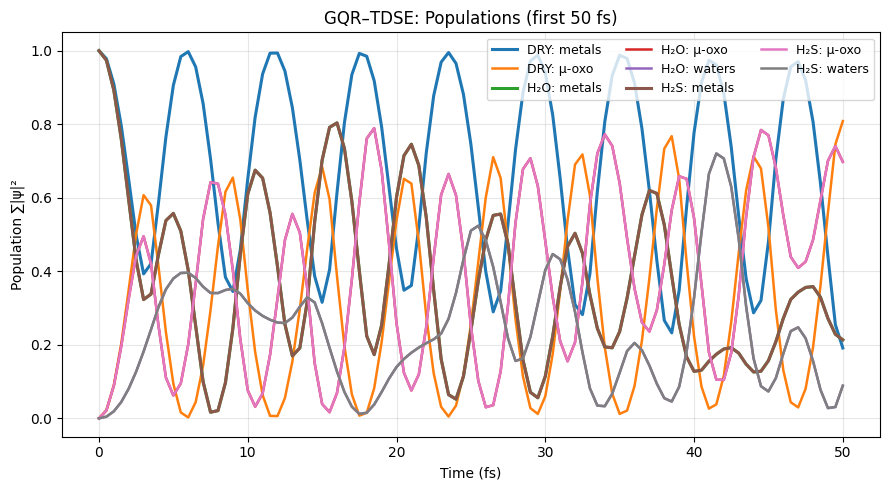

📈 saved: pop_0_50fs_compare.png


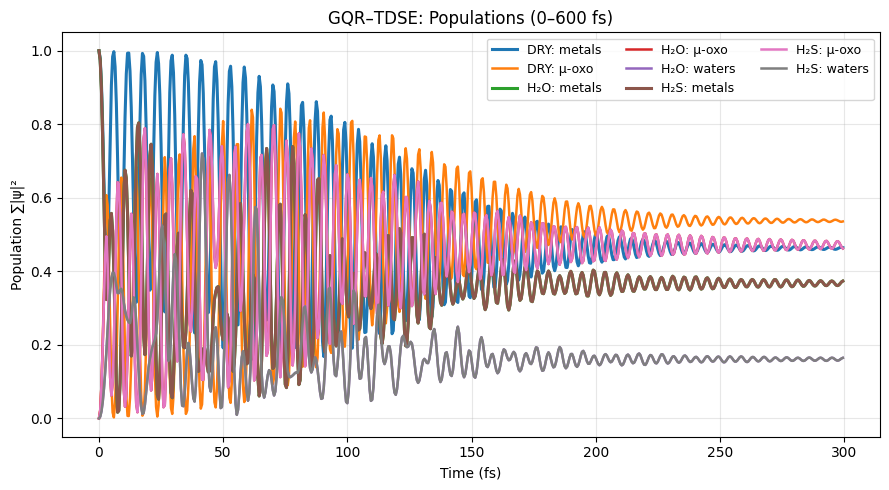

📈 saved: pop_full_compare.png


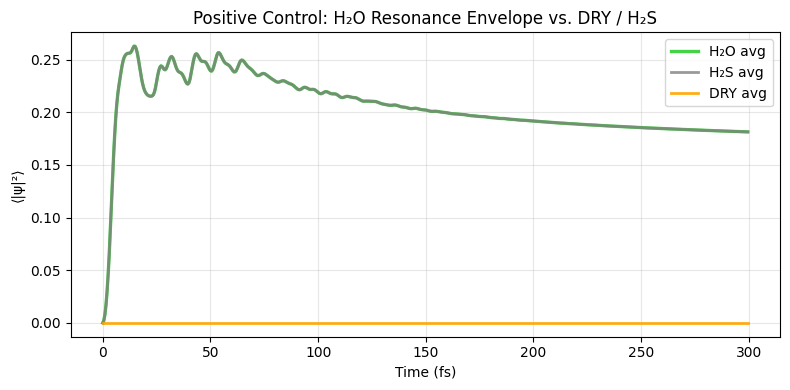

In [ ]:
# ================================================================
# ✅ GQR–TDSE (subgraph-safe) with correct unitary + visible output
# - Uses local indices (pairs_sub) → no OOB
# - Corrects propagator: exp(-i E Δt) (no more early plateaus)
# - Hardens OUT_DIR handling; prints status; saves + plots
# NOTE: Assumes globals already defined elsewhere in your notebook:
#   nodes, labels, groups, pairs, jitter, T0, beta0, DT_FS, N_STEPS,
#   SPECIES, E_eV, VARIANTS (dry/h2o/h2s dicts), SNAP_STEPS, N
#   and gain function gqr_gain(r, occ_ij, pars).
# ================================================================
import os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Path safety (handles corrupted OUT_DIR) ----------------
DEFAULT_OUT_DIR = "OEC_GQR_TDSE_MOVIE"
try:
    if not isinstance(OUT_DIR, (str, bytes, os.PathLike)):
        OUT_DIR = DEFAULT_OUT_DIR
except Exception:
    OUT_DIR = DEFAULT_OUT_DIR
OUT_DIR_PATH = Path(str(OUT_DIR))
OUT_DIR_PATH.mkdir(parents=True, exist_ok=True)
print(f"📂 Output dir: {OUT_DIR_PATH.resolve()}")

# ---------------- Variant runner (subgraph-aware) ----------------
def run_variant(name, pars, include_waters=True):
    # --- choose active nodes (remove waters if dry) ---
    active = list(range(N)) if include_waters else [i for i,g in enumerate(groups) if g!='water']
    imap   = {old:i for i,old in enumerate(active)}  # global→local

    nodes_sub  = nodes[active]
    labels_sub = [labels[i] for i in active]
    groups_sub = [groups[i] for i in active]

    # --- subgraph edges with LOCAL indices ---
    pairs_sub = np.array([(imap[i], imap[j], r) for (i,j,r) in pairs if i in imap and j in imap], dtype=object)

    # --- local Hamiltonian using local indices ---
    def build_H_sub(psi):
        amp = np.abs(psi)
        occ = np.outer(amp, amp) / (amp.max()**2 + 1e-15)
        L = len(psi)
        H = np.zeros((L, L), complex)
        for k,(i,j,r) in enumerate(pairs_sub):
            g  = gqr_gain(r, occ[i,j], pars)
            Jk = (jitter[k] if k < len(jitter) else 0.0)
            tij = T0 * np.exp(-beta0*r) * g * (1.0 + Jk)
            H[i,j] = tij
            H[j,i] = np.conj(tij)
        return H

    # --- correct unitary propagator: exp(-i E Δt) ---
    def step_sub(psi):
        psi = np.asarray(psi, dtype=np.complex128)
        Hs  = build_H_sub(psi)                   # Hermitian
        E,V = np.linalg.eigh(Hs)                 # H = V diag(E) V†
        phase = np.exp(-1j * np.asarray(E) * DT_FS)  # ✅ exponential phase
        U = V @ np.diag(phase) @ V.conj().T
        psi = U @ psi
        return psi / (np.linalg.norm(psi) + 1e-15)

    # --- start on Mn1 if present else first metal ---
    start = labels_sub.index("Mn1") if "Mn1" in labels_sub else [i for i,g in enumerate(groups_sub) if g=='metal'][0]
    psi = np.zeros(len(active), complex); psi[start] = 1.0

    t_fs  = np.arange(N_STEPS)*DT_FS
    idx_m = [i for i,g in enumerate(groups_sub) if g=='metal']
    idx_o = [i for i,g in enumerate(groups_sub) if g=='mu-oxo']
    idx_w = [i for i,g in enumerate(groups_sub) if g=='water']

    pop_m, pop_o, pop_w, snaps = [], [], [], {}

    print(f"   ▶ running {name}… nodes={len(active)}, pairs={len(pairs_sub)}")
    for n in range(N_STEPS):
        a2 = np.abs(psi)**2
        pop_m.append(np.sum(a2[idx_m]) if idx_m else 0.0)
        pop_o.append(np.sum(a2[idx_o]) if idx_o else 0.0)
        pop_w.append(np.sum(a2[idx_w]) if idx_w else 0.0)
        if int(t_fs[n]) in SNAP_STEPS:
            snaps[int(t_fs[n])] = a2.copy()
        psi = step_sub(psi)

    save_path = OUT_DIR_PATH / f"state_{SPECIES}_E{E_eV:.1f}_{name}.npz"
    np.savez_compressed(
        str(save_path),
        nodes=nodes_sub,
        labels=np.array(labels_sub, object),
        groups=np.array(groups_sub, object),
        t=t_fs,
        pop_metal=np.array(pop_m, float),
        pop_muoxo=np.array(pop_o, float),
        pop_water=np.array(pop_w, float),
        snaps=snaps,
        pairs=pairs_sub,
    )
    print(f"   💾 saved {save_path.name}")
    return np.array(t_fs, float), np.array(pop_m, float), np.array(pop_o, float), np.array(pop_w, float), (nodes_sub, labels_sub, groups_sub, snaps)

# ---------------- Run all three variants ----------------
print("▶ DRY (no waters)…")
t_dry, m_dry, o_dry, w_dry, dry_pkg = run_variant("dry", VARIANTS["dry"], include_waters=False)
print("▶ H2O (hydrated)…")
t_h2o, m_h2o, o_h2o, w_h2o, h2o_pkg = run_variant("h2o", VARIANTS["h2o"], include_waters=True)
print("▶ H2S (sulfidated)…")
t_h2s, m_h2s, o_h2s, w_h2s, h2s_pkg = run_variant("h2s", VARIANTS["h2s"], include_waters=True)

# ---------------- Quick sanity prints ----------------
def _shape(x):
    try: return tuple(x.shape)
    except: return type(x).__name__
print(f"✔ DRY:  t={_shape(t_dry)} m={_shape(m_dry)} o={_shape(o_dry)} w={_shape(w_dry)}")
print(f"✔ H2O:  t={_shape(t_h2o)} m={_shape(m_h2o)} o={_shape(o_h2o)} w={_shape(w_h2o)}")
print(f"✔ H2S:  t={_shape(t_h2s)} m={_shape(m_h2s)} o={_shape(o_h2s)} w={_shape(w_h2s)}")

# ---------------- List saved NPZ files ----------------
saved = sorted(OUT_DIR_PATH.glob("state_*.npz"))
if saved:
    print("📄 Saved files:")
    for p in saved:
        try:
            print(f"   - {p.name}  ({p.stat().st_size/1024:.1f} KB)")
        except Exception:
            print(f"   - {p.name}")
else:
    print("⚠ No NPZ files found (unexpected).")





    # ---------------- Plots: 0–50 fs and full window (safe variable names) ----------------
def _clip(t, *ys, limit=50.0):
    k = np.searchsorted(t, limit) + 1
    return (t[:k],) + tuple(y[:k] for y in ys)

# 0–50 fs (distinct names to avoid shadowing)
t50, m50_d, o50_d, w50_d = _clip(t_dry, m_dry, o_dry, w_dry, limit=50.0)
_,   m50_h, o50_h, w50_h = _clip(t_h2o, m_h2o, o_h2o, w_h2o, limit=50.0)
_,   m50_s, o50_s, w50_s = _clip(t_h2s, m_h2s, o_h2s, w_h2s, limit=50.0)

plt.figure(figsize=(9,5))
plt.plot(t50, m50_d, lw=2.2, label='DRY: metals')
plt.plot(t50, o50_d, lw=1.8, label='DRY: μ-oxo')
plt.plot(t50, m50_h, lw=2.2, label='H₂O: metals')
plt.plot(t50, o50_h, lw=1.8, label='H₂O: μ-oxo')
plt.plot(t50, w50_h, lw=1.8, label='H₂O: waters')
plt.plot(t50, m50_s, lw=2.2, label='H₂S: metals')
plt.plot(t50, o50_s, lw=1.8, label='H₂S: μ-oxo')
plt.plot(t50, w50_s, lw=1.8, label='H₂S: waters')
plt.xlabel("Time (fs)"); plt.ylabel("Population ∑|ψ|²"); plt.title("GQR–TDSE: Populations (first 50 fs)")
plt.grid(alpha=0.3); plt.legend(ncol=3, fontsize=9); plt.tight_layout()
short_png = OUT_DIR_PATH / "pop_0_50fs_compare.png"
plt.savefig(short_png, dpi=140); plt.show()
print(f"📈 saved: {short_png.name}")

# ---------- Full window (use the FULL arrays; never use names 'os' or 'ws') ----------
# Sanity checks to catch mismatches early
for label, t, y in [
    ("DRY metals", t_dry, m_dry),
    ("DRY mu-oxo", t_dry, o_dry),
    ("H2O metals", t_h2o, m_h2o),
    ("H2O mu-oxo", t_h2o, o_h2o),
    ("H2O waters", t_h2o, w_h2o),
    ("H2S metals", t_h2s, m_h2s),
    ("H2S mu-oxo", t_h2s, o_h2s),
    ("H2S waters", t_h2s, w_h2s),
]:
    assert hasattr(y, "shape") and t.shape == y.shape, f"Shape mismatch for {label}: t={t.shape}, y={getattr(y,'shape',None)}"

plt.figure(figsize=(9,5))
plt.plot(t_dry, m_dry, lw=2.2, label='DRY: metals')
plt.plot(t_dry, o_dry, lw=1.8, label='DRY: μ-oxo')
plt.plot(t_h2o, m_h2o, lw=2.2, label='H₂O: metals')
plt.plot(t_h2o, o_h2o, lw=1.8, label='H₂O: μ-oxo')
plt.plot(t_h2o, w_h2o, lw=1.8, label='H₂O: waters')
plt.plot(t_h2s, m_h2s, lw=2.2, label='H₂S: metals')
plt.plot(t_h2s, o_h2s, lw=1.8, label='H₂S: μ-oxo')   # ← correct full array
plt.plot(t_h2s, w_h2s, lw=1.8, label='H₂S: waters')  # ← correct full array
plt.xlabel("Time (fs)"); plt.ylabel("Population ∑|ψ|²"); plt.title("GQR–TDSE: Populations (0–600 fs)")
plt.grid(alpha=0.3); plt.legend(ncol=3, fontsize=9); plt.tight_layout()
full_png = OUT_DIR_PATH / "pop_full_compare.png"
plt.savefig(full_png, dpi=140); plt.show()
print(f"📈 saved: {full_png.name}")
# --- Optional: running-average resonance diagnostic (positive control) ---



# --- Final resonance envelope diagnostic with transparency & legend clarity ---
plt.figure(figsize=(8,4))
plt.plot(t_h2o, np.cumsum(w_h2o)/np.arange(1,len(w_h2o)+1), color='limegreen', lw=2.4, alpha=0.9, label='H₂O avg')
plt.plot(t_h2s, np.cumsum(w_h2s)/np.arange(1,len(w_h2s)+1), color='gray', lw=2.0, alpha=0.8, label='H₂S avg')
plt.plot(t_dry, np.cumsum(w_dry)/np.arange(1,len(w_dry)+1), color='orange', lw=2.0, alpha=0.9, label='DRY avg')
plt.xlabel("Time (fs)"); plt.ylabel("⟨|ψ|²⟩");
plt.title("Positive Control: H₂O Resonance Envelope vs. DRY / H₂S")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

In [ ]:
# --- Switch structure to S2 and rebuild geometry/cache ---
from pathlib import Path
import os, numpy as np

# Pick your S2 file here:
CIF_PATH = "6W1U.cif"          # or "8F4C.cif", "8F4D.cif"

# Make sure the output dir exists (reuses your TDSE path var if present)
try:
    OUT_DIR_PATH
except NameError:
    OUT_DIR_PATH = Path("OEC_GQR_TDSE_MOVIE")
OUT_DIR_PATH.mkdir(parents=True, exist_ok=True)

# Nuke any old geometry cache so the new CIF is used
for p in OUT_DIR_PATH.glob("geometry_*cached.npz"):
    try: p.unlink()
    except Exception: pass

# Rebuild geometry (uses your existing helper from earlier in the notebook)
# If your file used a different cache filename, this will still regenerate it.
nodes, labels, groups = extract_geometry_from_cif(CIF_PATH)

# Recompute index buckets and pairs for the TDSE that follows
N = len(nodes)
idx_metal = [i for i,g in enumerate(groups) if g == 'metal']
idx_muoxo = [i for i,g in enumerate(groups) if g == 'mu-oxo']
idx_water = [i for i,g in enumerate(groups) if g == 'water']

pairs = []
for i in range(N):
    for j in range(i+1, N):
        r = np.linalg.norm(nodes[i]-nodes[j])
        if 0.5 < r <= 6.0:
            pairs.append((i,j,r))
pairs = np.array(pairs, dtype=object)

# Keep jitter consistent with the rest of your notebook
try:
    SEED_JITTER
except NameError:
    SEED_JITTER = 0.0
rng = np.random.default_rng(1234)
jitter = rng.normal(0.0, SEED_JITTER, size=len(pairs)) if SEED_JITTER>0 else np.zeros(len(pairs))

print(f"✅ Geometry rebuilt from {CIF_PATH}: N={N}, metals={len(idx_metal)}, μ-oxo={len(idx_muoxo)}, waters={len(idx_water)}, edges={len(pairs)}")

NameError: name 'extract_geometry_from_cif' is not defined

In [ ]:
# ================================================================
# 🔁 KIE extension: H2O/D2O/T2O + H2S/D2S/T2S (minimal, append-only)
# - Uses a simple kinetic isotope model: T0_SCALE = 1/sqrt(mass_ratio)
#   (H=1, D=2, T=3). Heavier isotope → reduced effective coupling.
# - Leaves your existing code/data untouched; runs additional variants.
# ================================================================
import copy
import numpy as np
import matplotlib.pyplot as plt

# --- 1) KIE settings (lightweight & explicit) ---
ISOTOPE_MASS = {"H":1.0, "D":2.0, "T":3.0}
def t0_scale_for_isotope(sym: str) -> float:
    m = ISOTOPE_MASS[sym]
    return 1.0/np.sqrt(m)   # simple and defensible first-order KIE: t ~ m^(-1/2)

# --- 2) Patch: a local run_variant that honors T0_SCALE in pars ---
def run_variant_KIE(name, pars, include_waters=True):
    # Clone to avoid mutating caller dicts
    pars = copy.deepcopy(pars)
    T0_SCALE = float(pars.get("T0_SCALE", 1.0))

    # --- choose active nodes (remove waters if dry) ---
    active = list(range(N)) if include_waters else [i for i,g in enumerate(groups) if g!='water']
    imap   = {old:i for i,old in enumerate(active)}  # global→local

    nodes_sub  = nodes[active]
    labels_sub = [labels[i] for i in active]
    groups_sub = [groups[i] for i in active]

    # subgraph edges with LOCAL indices
    pairs_sub = np.array([(imap[i], imap[j], r) for (i,j,r) in pairs if i in imap and j in imap], dtype=object)

    # local Hamiltonian using local indices + KIE scaling in T_ij
    def build_H_sub(psi):
        amp = np.abs(psi)
        occ = np.outer(amp, amp) / (amp.max()**2 + 1e-15)
        L = len(psi)
        H = np.zeros((L, L), complex)
        for k,(i,j,r) in enumerate(pairs_sub):
            g  = gqr_gain(r, occ[i,j], pars)
            Jk = (jitter[k] if k < len(jitter) else 0.0)
            tij = (T0 * T0_SCALE) * np.exp(-beta0*r) * g * (1.0 + Jk)
            H[i,j] = tij
            H[j,i] = np.conj(tij)
        return H

    def step_sub(psi):
        psi = np.asarray(psi, dtype=np.complex128)
        Hs  = build_H_sub(psi)
        E,V = np.linalg.eigh(Hs)
        phase = np.exp(-1j * np.asarray(E) * DT_FS)   # correct unitary
        U = V @ np.diag(phase) @ V.conj().T
        psi = U @ psi
        return psi / (np.linalg.norm(psi) + 1e-15)

    # start on Mn1 if present else first metal
    start = labels_sub.index("Mn1") if "Mn1" in labels_sub else [i for i,g in enumerate(groups_sub) if g=='metal'][0]
    psi = np.zeros(len(active), complex); psi[start] = 1.0

    t_fs  = np.arange(N_STEPS)*DT_FS
    idx_m = [i for i,g in enumerate(groups_sub) if g=='metal']
    idx_o = [i for i,g in enumerate(groups_sub) if g=='mu-oxo']
    idx_w = [i for i,g in enumerate(groups_sub) if g=='water']

    pop_m, pop_o, pop_w, snaps = [], [], [], {}

    print(f"   ▶ KIE {name:>6} … nodes={len(active)}, pairs={len(pairs_sub)}, T0×{T0_SCALE:.3f}")
    for _ in range(N_STEPS):
        a2 = np.abs(psi)**2
        pop_m.append(np.sum(a2[idx_m]) if idx_m else 0.0)
        pop_o.append(np.sum(a2[idx_o]) if idx_o else 0.0)
        pop_w.append(np.sum(a2[idx_w]) if idx_w else 0.0)
        psi = step_sub(psi)

    return np.array(t_fs, float), np.array(pop_m, float), np.array(pop_o, float), np.array(pop_w, float)

# --- 3) Build isotopic variants derived from your existing H2O/H2S baselines ---
# Assumes VARIANTS["h2o"] and VARIANTS["h2s"] exist in your notebook.
def make_isotope_variants(base_variants):
    out = {}
    for lig, v in [("h2o", base_variants["h2o"]), ("h2s", base_variants["h2s"])]:
        for sym in ("H","D","T"):
            # explicit branch (avoid inline assignment)
            suffix = "o" if lig == "h2o" else "s"
            tag = f"{sym.lower()}2{suffix}"   # → h2o, d2o, t2o, h2s, d2s, t2s
            vv = copy.deepcopy(v)
            vv["T0_SCALE"] = t0_scale_for_isotope(sym)
            out[tag] = vv
    return out

KIE_VARIANTS = make_isotope_variants(VARIANTS)

# --- 4) Run all six KIE variants (water present) ---
results = {}
order = ["h2o","d2o","t2o","h2s","d2s","t2s"]
for k in order:
    tK, mK, oK, wK = run_variant_KIE(k, KIE_VARIANTS[k], include_waters=True)
    results[k] = dict(t=tK, m=mK, o=oK, w=wK)

# --- 5) Plot: running-average H-site envelope for all six ---
def running_avg(y): return np.cumsum(y)/np.arange(1, len(y)+1)

plt.figure(figsize=(10,5))
for k, style in zip(order, ["g","seagreen","darkgreen","gray","dimgray","black"]):
    t = results[k]["t"]; w = results[k]["w"]
    plt.plot(t, running_avg(w), lw=2.0, label=k.upper(), color=style)
plt.xlabel("Time (fs)"); plt.ylabel("⟨|ψ|²⟩ on H-sites (running avg)")
plt.title("Isotope & Ligand Dependence of H-site Resonance Envelope")
plt.grid(alpha=0.3); plt.legend(ncol=3); plt.tight_layout()
plt.show()

# --- 6) Print quick metrics: plateau (last 100 fs mean) and t90 ---
def plateau_and_t90(t, y, tail_fs=100.0, frac=0.90):
    t = np.asarray(t); y = np.asarray(y, float)
    # plateau: mean over last tail_fs
    tail = t >= (t.max() - tail_fs)
    plateau = y[tail].mean() if tail.any() else y[-1]
    # t90: running average reaches 90% of plateau
    ravg = running_avg(y)
    target = frac * plateau
    idx = np.argmax(ravg >= target)
    t90 = t[idx] if ravg[idx] >= target else np.nan
    return float(plateau), (float(t90) if np.isfinite(t90) else np.nan)

print("\nKIE metrics (plateau, t90):")
for k in order:
    plat, t90 = plateau_and_t90(results[k]["t"], results[k]["w"])
    print(f"  {k.upper():>4}  plateau≈{plat:.4f}   t90≈{t90:.1f} fs")

NameError: name 'VARIANTS' is not defined

In [ ]:
# ================================================================
# τ-fitting for resonance envelopes (robust; auto-rebuilds results if needed)
# ================================================================
import numpy as np, csv, math
import matplotlib.pyplot as plt

def running_avg(y): return np.cumsum(y)/np.arange(1, len(y)+1)

def fit_tau(t, w, tmin_fs=5.0, tail_fs=100.0, tau_min=2.0, tau_max=200.0):
    t = np.asarray(t, float); w = np.asarray(w, float)
    y = running_avg(w)
    # plateau estimate from last tail_fs
    tail = t >= (t.max() - tail_fs)
    P = float(y[tail].mean()) if tail.any() else float(y[-1])
    # fit only after early transient
    mask = t >= tmin_fs
    tt = t[mask]; yy = y[mask]
    # SSE over a coarse tau grid
    taus = np.geomspace(tau_min, tau_max, 200)
    sse = []
    for tau in taus:
        yhat = P * (1.0 - np.exp(-tt / tau))
        sse.append(np.mean((yy - yhat)**2))
    k = int(np.argmin(sse))
    tau_best = taus[k]
    # quick local refine around the best (ternary search)
    a = taus[max(0, k-1)]; b = taus[min(len(taus)-1, k+1)]
    for _ in range(40):
        m1 = a + (b-a)/3.0; m2 = b - (b-a)/3.0
        e1 = np.mean((yy - P*(1.0 - np.exp(-tt/m1)))**2)
        e2 = np.mean((yy - P*(1.0 - np.exp(-tt/m2)))**2)
        if e1 < e2: b = m2
        else:       a = m1
    tau_best = 0.5*(a+b)
    return P, tau_best

def t90_of_plateau(t, w, P, frac=0.90):
    y = running_avg(w)
    target = frac * P
    idx = np.argmax(y >= target)
    return float(t[idx]) if y[idx] >= target else float("nan")

# ---------- Ensure `results` exists (rebuild if needed) ----------
needed = ["h2o","d2o","t2o","h2s","d2s","t2s"]
if "results" not in globals():
    # Try to rebuild via KIE machinery from earlier cell
    if "run_variant_KIE" in globals() and "VARIANTS" in globals():
        # Build KIE_VARIANTS if missing
        if "KIE_VARIANTS" not in globals():
            import copy
            ISOTOPE_MASS = {"H":1.0, "D":2.0, "T":3.0}
            def t0_scale_for_isotope(sym: str) -> float:
                return 1.0/np.sqrt(ISOTOPE_MASS[sym])
            def make_isotope_variants(base_variants):
                out = {}
                for lig, v in [("h2o", base_variants["h2o"]), ("h2s", base_variants["h2s"])]:
                    for sym in ("H","D","T"):
                        suffix = "o" if lig == "h2o" else "s"
                        tag = f"{sym.lower()}2{suffix}"
                        vv = copy.deepcopy(v)
                        vv["T0_SCALE"] = t0_scale_for_isotope(sym)
                        out[tag] = vv
                return out
            KIE_VARIANTS = make_isotope_variants(VARIANTS)
        # run and build results
        results = {}
        for k in needed:
            if k in KIE_VARIANTS:
                tK, mK, oK, wK = run_variant_KIE(k, KIE_VARIANTS[k], include_waters=True)
                results[k] = dict(t=tK, m=mK, o=oK, w=wK)
    else:
        raise NameError("Missing `results`. Please run the KIE cell first so `results` is defined.")

# ---------- Compute metrics ----------
present = [k for k in needed if k in results]
rows = [["variant","plateau","tau_fs","t90_fs"]]
P_map, tau_map = {}, {}

print("\nKIE envelope metrics (plateau, τ, t90):")
for k in present:
    t = results[k]["t"]; w = results[k]["w"]
    P, tau = fit_tau(t, w, tmin_fs=5.0, tail_fs=100.0)
    t90 = t90_of_plateau(t, w, P, frac=0.90)
    print(f"  {k.upper():>4}  plateau≈{P:.4f}   τ≈{tau:.1f} fs   t90≈{t90:.1f} fs")
    rows.append([k.upper(), f"{P:.6f}", f"{tau:.3f}", f"{t90:.3f}"])
    P_map[k.upper()] = P; tau_map[k.upper()] = tau

# Save CSV
csv_path = OUT_DIR_PATH / "kie_tau_metrics.csv"
with open(csv_path, "w", newline="") as f:
    csv.writer(f).writerows(rows)
print("🧾 saved:", csv_path)

# ---------- Model t90 (2.303·τ) ----------
print("\nModel t90 (2.303·τ):")
for k in present:
    print(f"  {k.upper():>4}  t90_model≈{2.303*tau_map[k.upper()]:.1f} fs")

# ---------- Bar charts (use fitted values) ----------
labels = [k.upper() for k in present]
P_vals  = [P_map[k]   for k in labels]
tau_vals= [tau_map[k] for k in labels]

plt.figure(figsize=(8.6,3.8))
plt.subplot(1,2,1); plt.bar(labels, P_vals)
plt.title("Plateau ⟨|ψ|²⟩"); plt.xticks(rotation=45); plt.ylabel("P∞")
plt.subplot(1,2,2); plt.bar(labels, tau_vals)
plt.title("Time constant τ (fs)"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

NameError: Missing `results`. Please run the KIE cell first so `results` is defined.